### This notebook looks at the impact of systematically deleting SC ... to the OUTER networks i.e., from ntwx A to ntwx B, C, etc

#### In this notebook (based on the convo with "Dave"), I try to isolate the different FC NTwx, but strcuturally. 
##### I will then run whobpyt on these structurally isolated ntwx to see how it affects FC, potentially shedding some light on how FC ntwx emerge. 

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be first attempted for a single subject.  
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
from collections import Counter

In [3]:
import seaborn as sns
import scipy.stats as stats

In [4]:
import pickle

In [5]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [6]:
import re

In [7]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [8]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [9]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [10]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 59.3 s, sys: 668 ms, total: 1min
Wall time: 1min 9s


In [11]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.51 s, sys: 130 ms, total: 1.64 s
Wall time: 1.64 s


In [12]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [13]:
# Subj_164030_vis_lesion_cc_cut_fc_con_mat.txt
# Subj_164030_vis_lesion_fc_con_mat.txt

###  Takes 45 mins ... strap in!

In [14]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
# all_subs_vis_lesion_cc_cut = []

all_subs_sommot_lesion = []
# all_subs_sommot_lesion_cc_cut = []

all_subs_dorsattn_lesion = []
# all_subs_dorsattn_lesion_cc_cut = []

all_subs_ventattn_lesion = []
# all_subs_ventattn_lesion_cc_cut = []

all_subs_limbic_lesion = []
# all_subs_limbic_lesion_cc_cut = []

all_subs_fpn_lesion = []
# all_subs_fpn_lesion_cc_cut = []

all_subs_dmn_lesion = []
# all_subs_dmn_lesion_cc_cut = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_vis_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
#     all_subs_vis_lesion_cc_cut.append(ss_vis_lesion_cc_cut)
    

    ss_sommot_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_sommot_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_sommot_lesion.append(ss_sommot_lesion)
#     all_subs_sommot_lesion_cc_cut.append(ss_sommot_lesion_cc_cut)

    ss_dorsattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dorsattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dorsattn_lesion.append(ss_dorsattn_lesion)
#     all_subs_dorsattn_lesion_cc_cut.append(ss_dorsattn_lesion_cc_cut)
    

    ss_ventattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_ventattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_ventattn_lesion.append(ss_ventattn_lesion)
#     all_subs_ventattn_lesion_cc_cut.append(ss_ventattn_lesion_cc_cut)

    
    ss_limbic_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_limbic_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_limbic_lesion.append(ss_limbic_lesion)
#     all_subs_limbic_lesion_cc_cut.append(ss_limbic_lesion_cc_cut)

    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_fpn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)
#     all_subs_fpn_lesion_cc_cut.append(ss_fpn_lesion_cc_cut)

    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dmn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)
#     all_subs_dmn_lesion_cc_cut.append(ss_dmn_lesion_cc_cut)

CPU times: user 2min 33s, sys: 3.89 s, total: 2min 37s
Wall time: 6min 37s


In [15]:
all_subs_lesion_ntwx = [all_subs_vis_lesion,all_subs_sommot_lesion,
                        all_subs_dorsattn_lesion,all_subs_ventattn_lesion,
                        all_subs_limbic_lesion,all_subs_fpn_lesion,
                        all_subs_dmn_lesion]

In [16]:
# for now deal with avg fc of DMN lesion only (across all ntwx) ...
# This is OUTER connectivity ... i.e., the average ntwx conn to other ntwx (so Vis to SomMot, DorsAttn, ..., DMN etc)

# all_subs_og_whobpyt
# all_subs_dmn_lesion

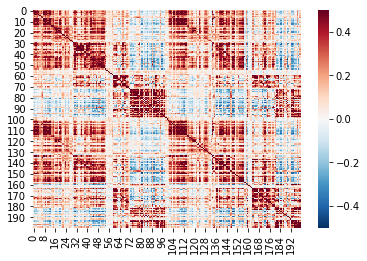

In [17]:
sns.heatmap(all_subs_emp_fc_mat[99], cmap='RdBu_r',center=0,vmax=0.5)

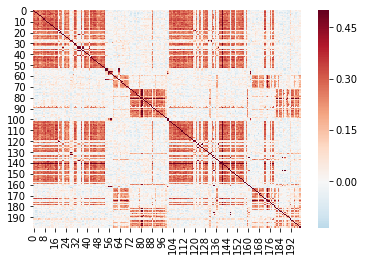

In [18]:
sns.heatmap(all_subs_og_whobpyt[99], cmap='RdBu_r',center=0,vmax=0.5)

In [19]:
i = 99

print(np.corrcoef(all_subs_og_whobpyt[i][mask], all_subs_emp_fc_mat[i][mask])[0][1])

0.6288580771510476


In [20]:
from numpy.polynomial.polynomial import polyfit

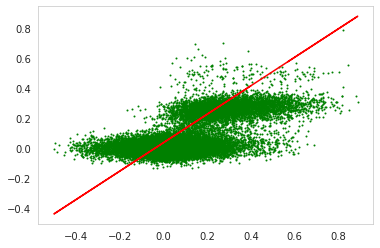

In [21]:
rww_test = all_subs_og_whobpyt[99][mask].flatten()

rww_test2 = all_subs_emp_fc_mat[99][mask].flatten()

m, b = np.polyfit(rww_test, rww_test2, 1)

sns.set_style('whitegrid')
fig,ax = plt.subplots()
plt.scatter(rww_test2, rww_test, color='green',s=1)
plt.plot(rww_test2, m*rww_test2 + b, color='red')
plt.grid(visible=False)

plt.show()

In [22]:
# for i in range(10):
#     print(np.corrcoef(all_subs_og_whobpyt[i][mask], all_subs_emp_fc_mat[i][mask])[0][1])

In [23]:
# for i in range(10):
#     rww_test = all_subs_og_whobpyt[i][mask].flatten()

#     rww_test2 = all_subs_emp_fc_mat[i][mask].flatten()

#     m, b = np.polyfit(rww_test, rww_test2, 1)

#     sns.set_style('whitegrid')
#     fig,ax = plt.subplots()
#     plt.scatter(rww_test2, rww_test, color='green',s=1)
#     plt.plot(rww_test2, m*rww_test2 + b, color='red')
#     plt.grid(visible=False)

#     plt.show()

In [24]:
corrs_list = []
for i in range(200):
    corrs_list.append(np.corrcoef(all_subs_emp_fc_mat[i][mask], all_subs_og_whobpyt[i][mask])[0][1])

In [25]:
# corrs_list

In [26]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [27]:
# vis --> (0,14,100,115)
# sommot --> (14,30,115,134)
# dorsattn --> (30,43,134,147)
# ventattn --> (43,54,147,158)
# limbic --> (54,60,158,164)
# fpn --> (60,73,164,181)
# dmn --> (73,100,181,200)

In [75]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

In [202]:
def outer_ntwx_only_fc(fc, sub, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = fc[sub][a:b, 0:14]
    lh_ntwx_to_rh_vis = fc[sub][a:b, 100:115]
    
    lh_ntwx_to_lh_sommot = fc[sub][a:b, 14:30]
    lh_ntwx_to_rh_sommot = fc[sub][a:b, 115:134]
    
    lh_ntwx_to_lh_dorsattn = fc[sub][a:b, 30:43]
    lh_ntwx_to_rh_dorsattn = fc[sub][a:b, 134:147]
    
    lh_ntwx_to_lh_ventattn = fc[sub][a:b, 43:54]
    lh_ntwx_to_rh_ventattn = fc[sub][a:b, 147:158]
    
    lh_ntwx_to_lh_limbic = fc[sub][a:b, 54:60]
    lh_ntwx_to_rh_limbic = fc[sub][a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = fc[sub][a:b, 60:73]
    lh_ntwx_to_rh_fpn = fc[sub][a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = fc[sub][a:b, 73:100]
    lh_ntwx_to_rh_dmn = fc[sub][a:b, 181:200]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = fc[sub][c:d, 0:14]
    rh_ntwx_to_rh_vis = fc[sub][c:d, 100:115]
    
    rh_ntwx_to_lh_sommot = fc[sub][c:d, 14:30]
    rh_ntwx_to_rh_sommot = fc[sub][c:d, 115:134]
    
    rh_ntwx_to_lh_dorsattn = fc[sub][c:d, 30:43]
    rh_ntwx_to_rh_dorsattn = fc[sub][c:d, 134:147]
    
    rh_ntwx_to_lh_ventattn = fc[sub][c:d, 43:54]
    rh_ntwx_to_rh_ventattn = fc[sub][c:d, 147:158]
    
    rh_ntwx_to_lh_limbic = fc[sub][c:d, 54:60]
    rh_ntwx_to_rh_limbic = fc[sub][c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = fc[sub][c:d, 60:73]
    rh_ntwx_to_rh_fpn = fc[sub][c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = fc[sub][c:d, 73:100]
    rh_ntwx_to_rh_dmn = fc[sub][c:d, 181:200]
        
    mean_ntwx_to_vis_fc = (np.mean(lh_ntwx_to_lh_vis) + (np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis))/2 + np.mean(rh_ntwx_to_rh_vis))#/4
    mean_ntwx_to_sommot_fc = (np.mean(lh_ntwx_to_lh_sommot) + (np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot))/2 + np.mean(rh_ntwx_to_rh_sommot))#/4
    mean_ntwx_to_dorsattn_fc = (np.mean(lh_ntwx_to_lh_dorsattn) + (np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn))/2 + np.mean(rh_ntwx_to_rh_dorsattn))#/4
    mean_ntwx_to_ventattn_fc = (np.mean(lh_ntwx_to_lh_ventattn) + (np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn))/2 + np.mean(rh_ntwx_to_rh_ventattn))#/4
    mean_ntwx_to_limbic_fc = (np.mean(lh_ntwx_to_lh_limbic) + (np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic))/2 + np.mean(rh_ntwx_to_rh_limbic))#/4
    mean_ntwx_to_fpn_fc = (np.mean(lh_ntwx_to_lh_fpn) + (np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn))/2 + np.mean(rh_ntwx_to_rh_fpn))#/4
    mean_ntwx_to_dmn_fc = (np.mean(lh_ntwx_to_lh_dmn) + (np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn))/2 + np.mean(rh_ntwx_to_rh_dmn))#/4
    
    
    return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
    
#     if num == 0:
#         return mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 1:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 2:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 3:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 4:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 5:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_dmn_fc
#     elif num == 6:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc

### original WhoBPyT

In [203]:
%%time

all_subs_vis_to_other_ntwx = []
all_subs_sommot_to_other_ntwx = []
all_subs_dorsattn_to_other_ntwx = []
all_subs_ventattn_to_other_ntwx = []
all_subs_limbic_to_other_ntwx = []
all_subs_fpn_to_other_ntwx = []
all_subs_dmn_to_other_ntwx = []

for i in range(200):
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,0)
    all_subs_vis_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,1)
    all_subs_sommot_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,2)
    all_subs_dorsattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,3)
    all_subs_ventattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,4)
    all_subs_limbic_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,5)
    all_subs_fpn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,6)
    all_subs_dmn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

CPU times: user 883 ms, sys: 13.8 ms, total: 897 ms
Wall time: 896 ms


In [204]:
og_whobpyt_vis_to_other_ntwx = np.mean(all_subs_vis_to_other_ntwx,axis=0)
og_whobpyt_sommot_to_other_ntwx = np.mean(all_subs_sommot_to_other_ntwx,axis=0)
og_whobpyt_dorsattn_to_other_ntwx = np.mean(all_subs_dorsattn_to_other_ntwx,axis=0)
og_whobpyt_ventattn_to_other_ntwx = np.mean(all_subs_ventattn_to_other_ntwx,axis=0)
og_whobpyt_limbic_to_other_ntwx = np.mean(all_subs_limbic_to_other_ntwx,axis=0)
og_whobpyt_fpn_to_other_ntwx = np.mean(all_subs_fpn_to_other_ntwx,axis=0)
og_whobpyt_dmn_to_other_ntwx = np.mean(all_subs_dmn_to_other_ntwx,axis=0)

In [205]:
# Across all 200 subs
og_whobpyt_outer_to_other_ntwx  = [og_whobpyt_vis_to_other_ntwx,og_whobpyt_sommot_to_other_ntwx,
                                   og_whobpyt_dorsattn_to_other_ntwx,og_whobpyt_ventattn_to_other_ntwx,
                                   og_whobpyt_limbic_to_other_ntwx,og_whobpyt_fpn_to_other_ntwx,
                                   og_whobpyt_dmn_to_other_ntwx]

### Lesion WhoBPyT

In [206]:
def get_outer_ntwx_fc(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions = np.mean(all_subs_vis_to_other_ntwx_lesions,axis=0)
    mean_all_subs_sommot_to_other_ntwx_lesions = np.mean(all_subs_sommot_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dorsattn_to_other_ntwx_lesions = np.mean(all_subs_dorsattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_ventattn_to_other_ntwx_lesions = np.mean(all_subs_ventattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_limbic_to_other_ntwx_lesions = np.mean(all_subs_limbic_to_other_ntwx_lesions,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions = np.mean(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions = np.mean(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions,mean_all_subs_sommot_to_other_ntwx_lesions,mean_all_subs_dorsattn_to_other_ntwx_lesions,mean_all_subs_ventattn_to_other_ntwx_lesions,mean_all_subs_limbic_to_other_ntwx_lesions,mean_all_subs_fpn_to_other_ntwx_lesions,mean_all_subs_dmn_to_other_ntwx_lesions

In [207]:
def get_outer_ntwx_fc_all_subs(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    return all_subs_vis_to_other_ntwx_lesions,all_subs_sommot_to_other_ntwx_lesions,all_subs_dorsattn_to_other_ntwx_lesions,all_subs_ventattn_to_other_ntwx_lesions,all_subs_limbic_to_other_ntwx_lesions,all_subs_fpn_to_other_ntwx_lesions,all_subs_dmn_to_other_ntwx_lesions

In [208]:
len(all_subs_vis_lesion)

200

In [209]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

vis_lesion_vis_to_other_ntwx, vis_lesion_sommot_to_other_ntwx, vis_lesion_dorsattn_to_other_ntwx, vis_lesion_ventattn_to_other_ntwx, vis_lesion_limbic_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_vis_lesion)

sommot_lesion_vis_to_other_ntwx, sommot_lesion_sommot_to_other_ntwx, sommot_lesion_dorsattn_to_other_ntwx, sommot_lesion_ventattn_to_other_ntwx, sommot_lesion_limbic_to_other_ntwx, sommot_lesion_fpn_to_other_ntwx, sommot_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_sommot_lesion)

dorsattn_lesion_vis_to_other_ntwx, dorsattn_lesion_sommot_to_other_ntwx, dorsattn_lesion_dorsattn_to_other_ntwx, dorsattn_lesion_ventattn_to_other_ntwx, dorsattn_lesion_limbic_to_other_ntwx, dorsattn_lesion_fpn_to_other_ntwx, dorsattn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_dorsattn_lesion)

ventattn_lesion_vis_to_other_ntwx, ventattn_lesion_sommot_to_other_ntwx, ventattn_lesion_dorsattn_to_other_ntwx, ventattn_lesion_ventattn_to_other_ntwx, ventattn_lesion_limbic_to_other_ntwx, ventattn_lesion_fpn_to_other_ntwx, ventattn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_ventattn_lesion)

limbic_lesion_vis_to_other_ntwx, limbic_lesion_sommot_to_other_ntwx, limbic_lesion_dorsattn_to_other_ntwx, limbic_lesion_ventattn_to_other_ntwx, limbic_lesion_limbic_to_other_ntwx, limbic_lesion_fpn_to_other_ntwx, limbic_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_limbic_lesion)

fpn_lesion_vis_to_other_ntwx, fpn_lesion_sommot_to_other_ntwx, fpn_lesion_dorsattn_to_other_ntwx, fpn_lesion_ventattn_to_other_ntwx, fpn_lesion_limbic_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_fpn_lesion)

dmn_lesion_vis_to_other_ntwx, dmn_lesion_sommot_to_other_ntwx, dmn_lesion_dorsattn_to_other_ntwx, dmn_lesion_ventattn_to_other_ntwx, dmn_lesion_limbic_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_dmn_lesion)


CPU times: user 5.89 s, sys: 44.4 ms, total: 5.94 s
Wall time: 5.87 s


In [210]:
%%time

# For stats

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

vis_lesion_all_subs_vis_to_other_ntwx, vis_lesion_all_subs_smt_to_other_ntwx, vis_lesion_all_subs_dan_to_other_ntwx, vis_lesion_all_subs_van_to_other_ntwx, vis_lesion_all_subs_lim_to_other_ntwx, vis_lesion_all_subs_fpn_to_other_ntwx, vis_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_vis_lesion)

smt_lesion_all_subs_vis_to_other_ntwx, smt_lesion_all_subs_smt_to_other_ntwx, smt_lesion_all_subs_dan_to_other_ntwx, smt_lesion_all_subs_van_to_other_ntwx, smt_lesion_all_subs_lim_to_other_ntwx, smt_lesion_all_subs_fpn_to_other_ntwx, smt_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_sommot_lesion)

dan_lesion_all_subs_vis_to_other_ntwx, dan_lesion_all_subs_smt_to_other_ntwx, dan_lesion_all_subs_dan_to_other_ntwx, dan_lesion_all_subs_van_to_other_ntwx, dan_lesion_all_subs_lim_to_other_ntwx, dan_lesion_all_subs_fpn_to_other_ntwx, dan_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_dorsattn_lesion)

van_lesion_all_subs_vis_to_other_ntwx, van_lesion_all_subs_smt_to_other_ntwx, van_lesion_all_subs_dan_to_other_ntwx, van_lesion_all_subs_van_to_other_ntwx, van_lesion_all_subs_lim_to_other_ntwx, van_lesion_all_subs_fpn_to_other_ntwx, van_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_ventattn_lesion)

lim_lesion_all_subs_vis_to_other_ntwx, lim_lesion_all_subs_smt_to_other_ntwx, lim_lesion_all_subs_dan_to_other_ntwx, lim_lesion_all_subs_van_to_other_ntwx, lim_lesion_all_subs_lim_to_other_ntwx, lim_lesion_all_subs_fpn_to_other_ntwx, lim_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_limbic_lesion)

fpn_lesion_all_subs_vis_to_other_ntwx, fpn_lesion_all_subs_smt_to_other_ntwx, fpn_lesion_all_subs_dan_to_other_ntwx, fpn_lesion_all_subs_van_to_other_ntwx, fpn_lesion_all_subs_lim_to_other_ntwx, fpn_lesion_all_subs_fpn_to_other_ntwx, fpn_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_fpn_lesion)

dmn_lesion_all_subs_vis_to_other_ntwx, dmn_lesion_all_subs_smt_to_other_ntwx, dmn_lesion_all_subs_dan_to_other_ntwx, dmn_lesion_all_subs_van_to_other_ntwx, dmn_lesion_all_subs_lim_to_other_ntwx, dmn_lesion_all_subs_fpn_to_other_ntwx, dmn_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_dmn_lesion)


CPU times: user 5.82 s, sys: 96.2 ms, total: 5.92 s
Wall time: 5.86 s


In [211]:
og_whobpyt_all_subs_vis_to_other_ntwx, og_whobpyt_all_subs_smt_to_other_ntwx, og_whobpyt_all_subs_dan_to_other_ntwx, og_whobpyt_all_subs_van_to_other_ntwx, og_whobpyt_all_subs_lim_to_other_ntwx, og_whobpyt_all_subs_fpn_to_other_ntwx, og_whobpyt_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_og_whobpyt)


In [212]:
vis_lesion_outer_to_other_ntwx = [vis_lesion_vis_to_other_ntwx, vis_lesion_sommot_to_other_ntwx, vis_lesion_dorsattn_to_other_ntwx, vis_lesion_ventattn_to_other_ntwx, vis_lesion_limbic_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx]
sommot_lesion_outer_to_other_ntwx = [sommot_lesion_vis_to_other_ntwx, sommot_lesion_sommot_to_other_ntwx, sommot_lesion_dorsattn_to_other_ntwx, sommot_lesion_ventattn_to_other_ntwx, sommot_lesion_limbic_to_other_ntwx, sommot_lesion_fpn_to_other_ntwx, sommot_lesion_dmn_to_other_ntwx]
dorsattn_lesion_outer_to_other_ntwx = [dorsattn_lesion_vis_to_other_ntwx, dorsattn_lesion_sommot_to_other_ntwx, dorsattn_lesion_dorsattn_to_other_ntwx, dorsattn_lesion_ventattn_to_other_ntwx, dorsattn_lesion_limbic_to_other_ntwx, dorsattn_lesion_fpn_to_other_ntwx, dorsattn_lesion_dmn_to_other_ntwx]
ventattn_lesion_outer_to_other_ntwx = [ventattn_lesion_vis_to_other_ntwx, ventattn_lesion_sommot_to_other_ntwx, ventattn_lesion_dorsattn_to_other_ntwx, ventattn_lesion_ventattn_to_other_ntwx, ventattn_lesion_limbic_to_other_ntwx, ventattn_lesion_fpn_to_other_ntwx, ventattn_lesion_dmn_to_other_ntwx]
limbic_lesion_outer_to_other_ntwx = [limbic_lesion_vis_to_other_ntwx, limbic_lesion_sommot_to_other_ntwx, limbic_lesion_dorsattn_to_other_ntwx, limbic_lesion_ventattn_to_other_ntwx, limbic_lesion_limbic_to_other_ntwx, limbic_lesion_fpn_to_other_ntwx, limbic_lesion_dmn_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx = [fpn_lesion_vis_to_other_ntwx, fpn_lesion_sommot_to_other_ntwx, fpn_lesion_dorsattn_to_other_ntwx, fpn_lesion_ventattn_to_other_ntwx, fpn_lesion_limbic_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx = [dmn_lesion_vis_to_other_ntwx, dmn_lesion_sommot_to_other_ntwx, dmn_lesion_dorsattn_to_other_ntwx, dmn_lesion_ventattn_to_other_ntwx, dmn_lesion_limbic_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx]

In [213]:
# For stats

In [214]:
og_whobpyt_all_subs_outer_to_other_ntwx = [og_whobpyt_all_subs_vis_to_other_ntwx, og_whobpyt_all_subs_smt_to_other_ntwx, og_whobpyt_all_subs_dan_to_other_ntwx, og_whobpyt_all_subs_van_to_other_ntwx, og_whobpyt_all_subs_lim_to_other_ntwx, og_whobpyt_all_subs_fpn_to_other_ntwx, og_whobpyt_all_subs_dmn_to_other_ntwx]

vis_lesion_all_subs_outer_to_other_ntwx = [vis_lesion_all_subs_vis_to_other_ntwx, vis_lesion_all_subs_smt_to_other_ntwx, vis_lesion_all_subs_dan_to_other_ntwx, vis_lesion_all_subs_van_to_other_ntwx, vis_lesion_all_subs_lim_to_other_ntwx, vis_lesion_all_subs_fpn_to_other_ntwx, vis_lesion_all_subs_dmn_to_other_ntwx]
smt_lesion_all_subs_outer_to_other_ntwx = [smt_lesion_all_subs_vis_to_other_ntwx, smt_lesion_all_subs_smt_to_other_ntwx, smt_lesion_all_subs_dan_to_other_ntwx, smt_lesion_all_subs_van_to_other_ntwx, smt_lesion_all_subs_lim_to_other_ntwx, smt_lesion_all_subs_fpn_to_other_ntwx, smt_lesion_all_subs_dmn_to_other_ntwx]
dan_lesion_all_subs_outer_to_other_ntwx = [dan_lesion_all_subs_vis_to_other_ntwx, dan_lesion_all_subs_smt_to_other_ntwx, dan_lesion_all_subs_dan_to_other_ntwx, dan_lesion_all_subs_van_to_other_ntwx, dan_lesion_all_subs_lim_to_other_ntwx, dan_lesion_all_subs_fpn_to_other_ntwx, dan_lesion_all_subs_dmn_to_other_ntwx]
van_lesion_all_subs_outer_to_other_ntwx = [van_lesion_all_subs_vis_to_other_ntwx, van_lesion_all_subs_smt_to_other_ntwx, van_lesion_all_subs_dan_to_other_ntwx, van_lesion_all_subs_van_to_other_ntwx, van_lesion_all_subs_lim_to_other_ntwx, van_lesion_all_subs_fpn_to_other_ntwx, van_lesion_all_subs_dmn_to_other_ntwx]
lim_lesion_all_subs_outer_to_other_ntwx = [lim_lesion_all_subs_vis_to_other_ntwx, lim_lesion_all_subs_smt_to_other_ntwx, lim_lesion_all_subs_dan_to_other_ntwx, lim_lesion_all_subs_van_to_other_ntwx, lim_lesion_all_subs_lim_to_other_ntwx, lim_lesion_all_subs_fpn_to_other_ntwx, lim_lesion_all_subs_dmn_to_other_ntwx]
fpn_lesion_all_subs_outer_to_other_ntwx = [fpn_lesion_all_subs_vis_to_other_ntwx, fpn_lesion_all_subs_smt_to_other_ntwx, fpn_lesion_all_subs_dan_to_other_ntwx, fpn_lesion_all_subs_van_to_other_ntwx, fpn_lesion_all_subs_lim_to_other_ntwx, fpn_lesion_all_subs_fpn_to_other_ntwx, fpn_lesion_all_subs_dmn_to_other_ntwx]
dmn_lesion_all_subs_outer_to_other_ntwx = [dmn_lesion_all_subs_vis_to_other_ntwx, dmn_lesion_all_subs_smt_to_other_ntwx, dmn_lesion_all_subs_dan_to_other_ntwx, dmn_lesion_all_subs_van_to_other_ntwx, dmn_lesion_all_subs_lim_to_other_ntwx, dmn_lesion_all_subs_fpn_to_other_ntwx, dmn_lesion_all_subs_dmn_to_other_ntwx]

In [215]:
og_whobpyt_outer_to_other_ntwx = [arr.tolist() for arr in og_whobpyt_outer_to_other_ntwx]


In [216]:
# og_whobpyt_outer_to_other_ntwx

In [217]:
vis_lesion_outer_to_other_ntwx = [arr.tolist() for arr in vis_lesion_outer_to_other_ntwx]
sommot_lesion_outer_to_other_ntwx = [arr.tolist() for arr in sommot_lesion_outer_to_other_ntwx]
dorsattn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in dorsattn_lesion_outer_to_other_ntwx]
ventattn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in ventattn_lesion_outer_to_other_ntwx]
limbic_lesion_outer_to_other_ntwx = [arr.tolist() for arr in limbic_lesion_outer_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in fpn_lesion_outer_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in dmn_lesion_outer_to_other_ntwx]

In [218]:
# for i in range(7):
#     print(_var_temp[i][i][i])

In [219]:
_var = [og_whobpyt_outer_to_other_ntwx,
vis_lesion_outer_to_other_ntwx,
sommot_lesion_outer_to_other_ntwx,
dorsattn_lesion_outer_to_other_ntwx,
ventattn_lesion_outer_to_other_ntwx,
limbic_lesion_outer_to_other_ntwx,
fpn_lesion_outer_to_other_ntwx,
dmn_lesion_outer_to_other_ntwx]

In [220]:
data = _var.copy()

In [221]:
len(og_whobpyt_outer_to_other_ntwx)

7

In [222]:
og_whobpyt_outer_to_other_ntwx[0]

[0.7415152417495467,
 0.35318214756106686,
 0.48005065900967897,
 0.3972418354958724,
 0.03318958197709804,
 0.13924267020266273,
 0.09993518499791365]

In [223]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

#### Visual

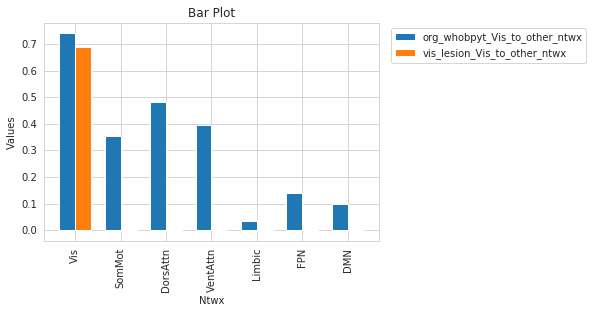

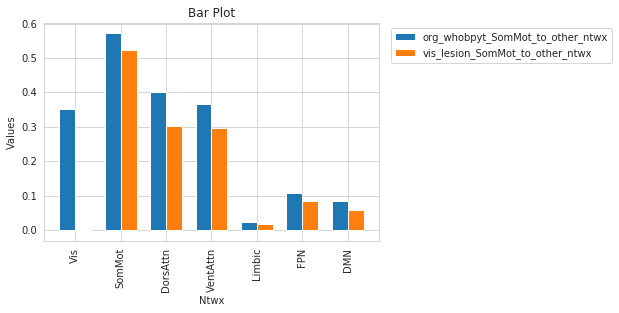

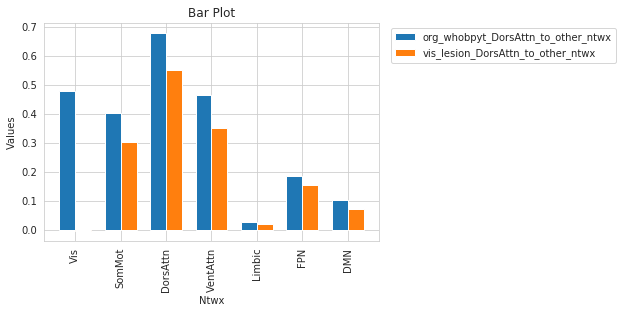

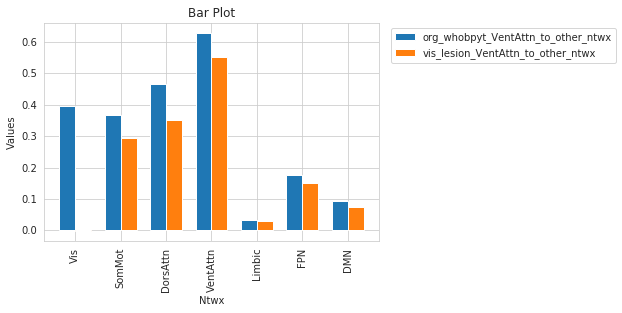

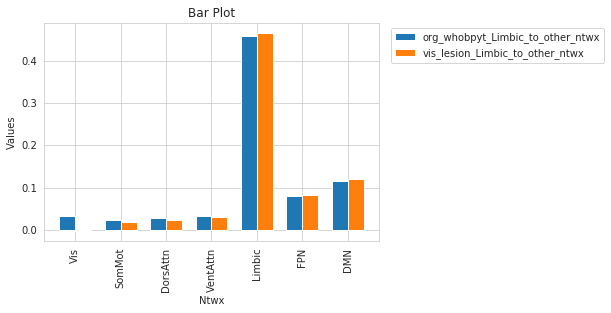

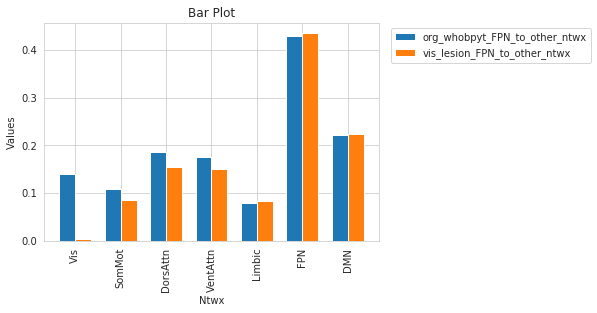

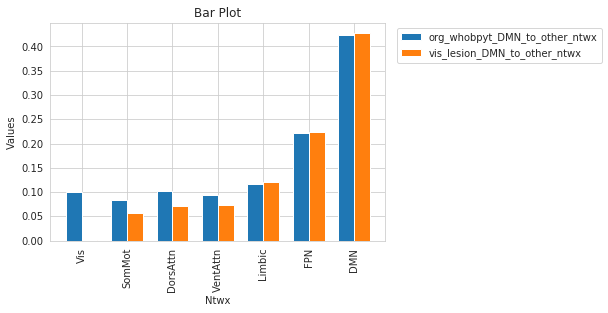

In [224]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], vis_lesion_outer_to_other_ntwx[j], width, label='vis_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### SomMot

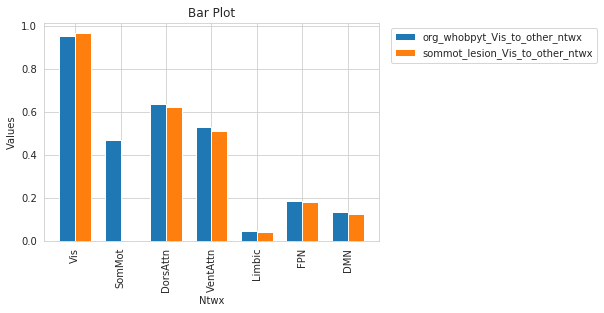

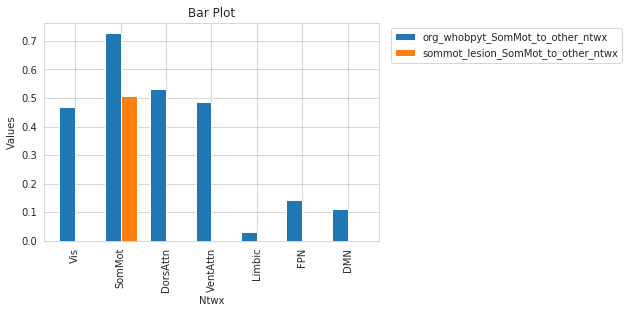

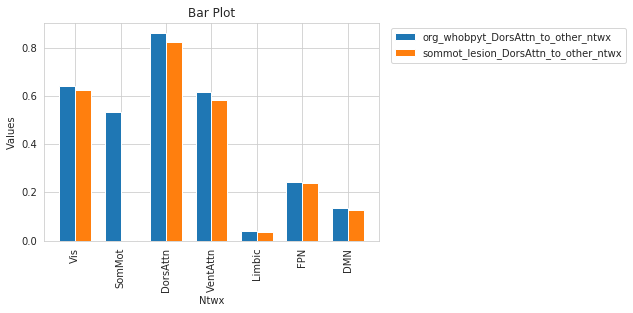

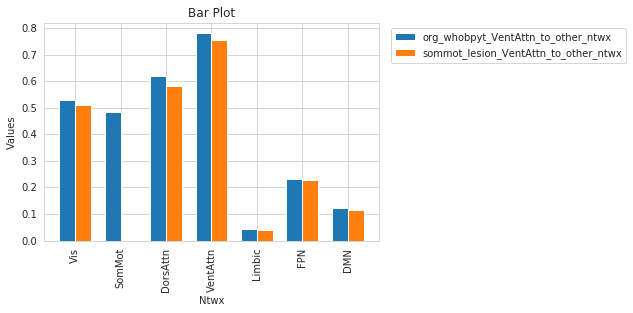

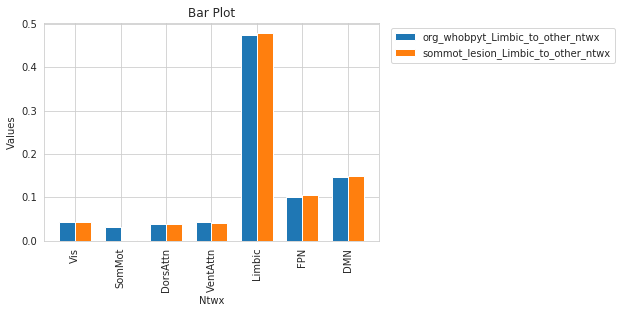

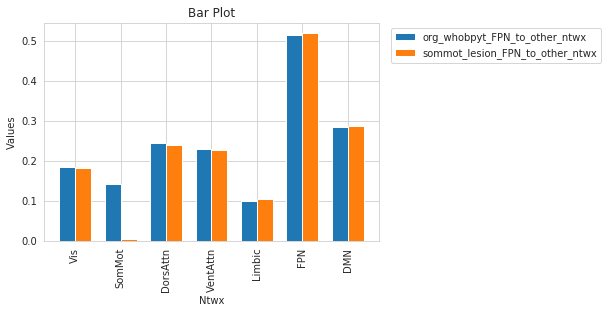

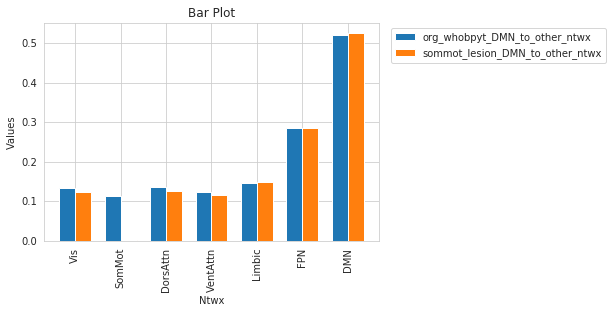

In [198]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], sommot_lesion_outer_to_other_ntwx[j], width, label='sommot_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DorsAttn

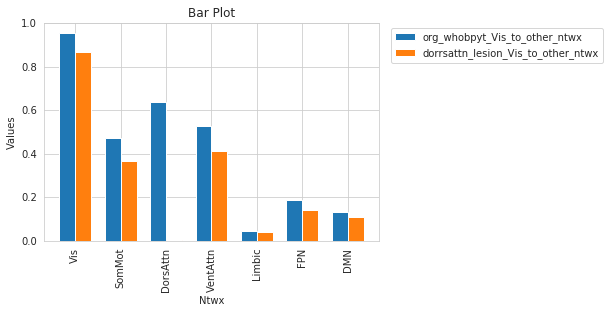

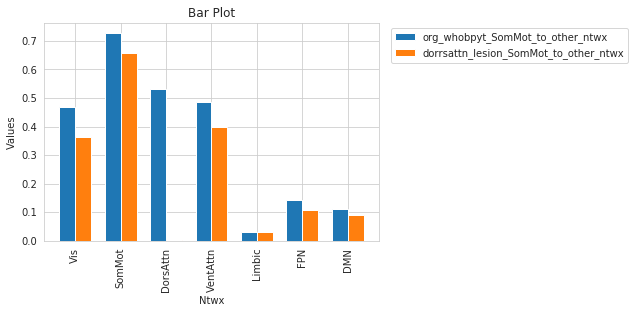

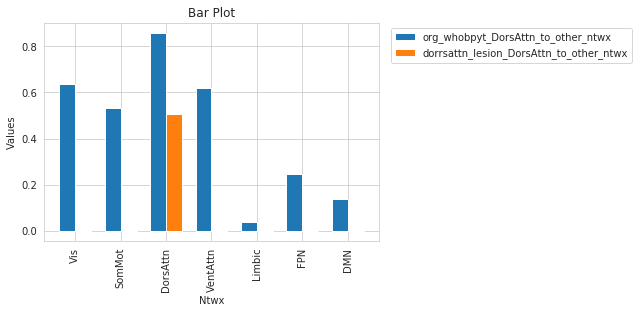

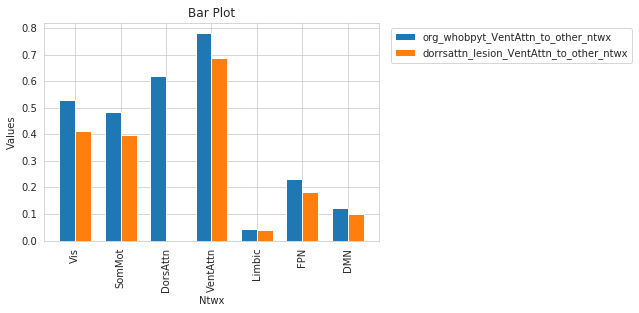

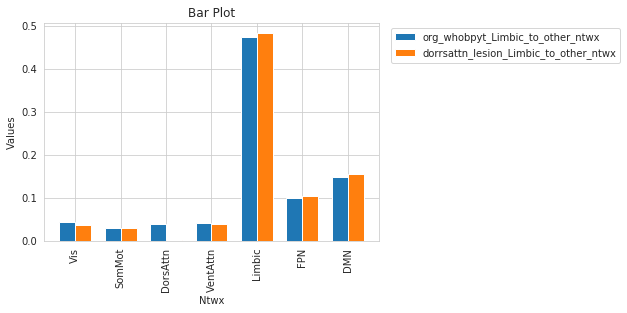

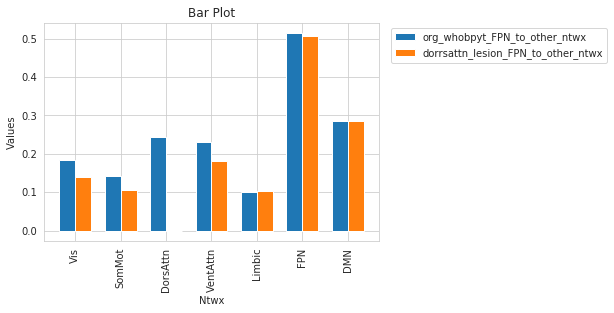

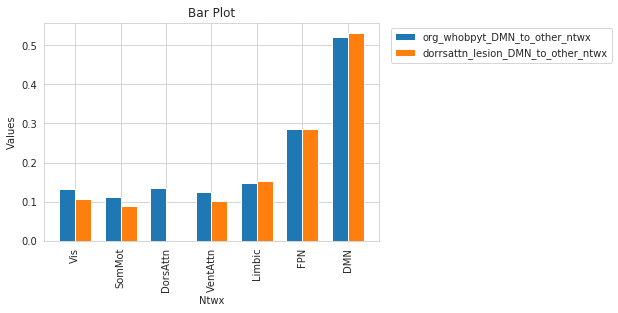

In [199]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], dorsattn_lesion_outer_to_other_ntwx[j], width, label='dorrsattn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### VentAttn

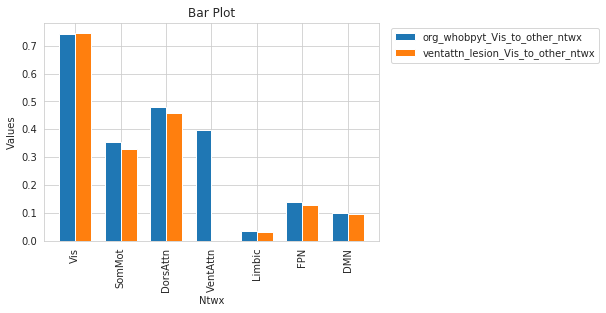

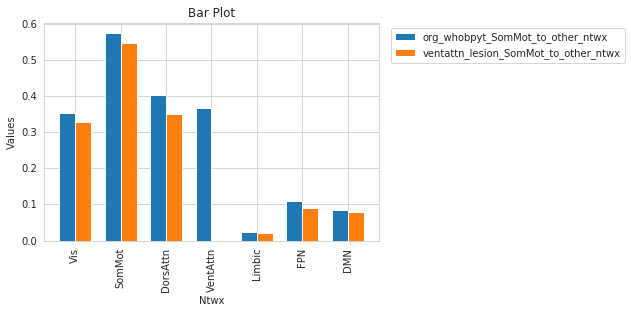

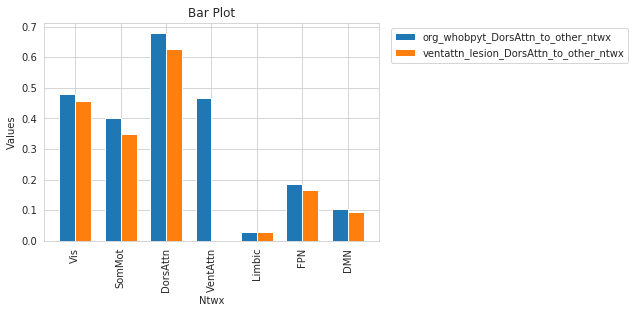

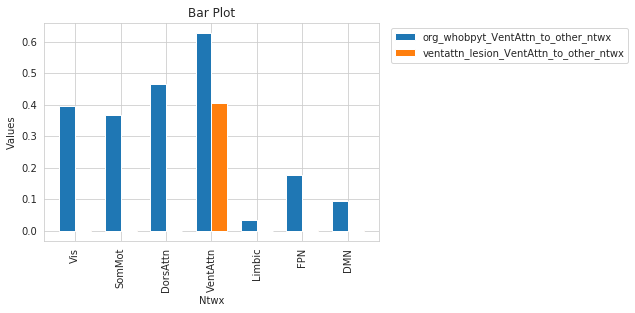

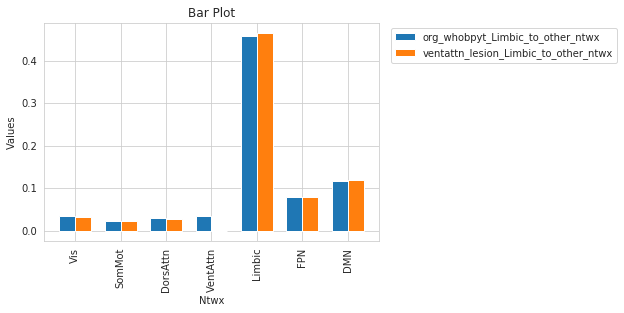

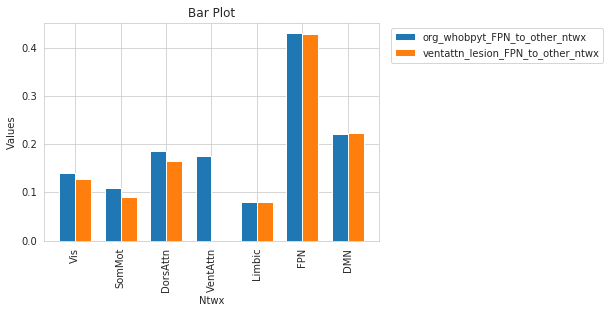

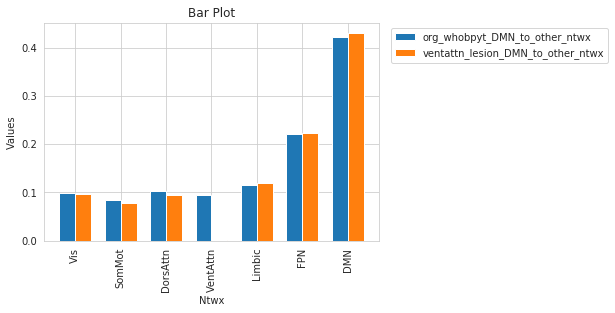

In [234]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], ventattn_lesion_outer_to_other_ntwx[j], width, label='ventattn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### Limbic

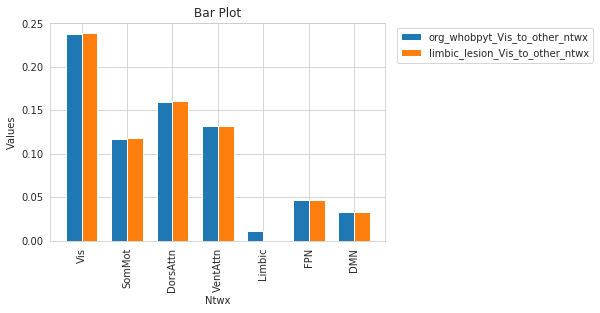

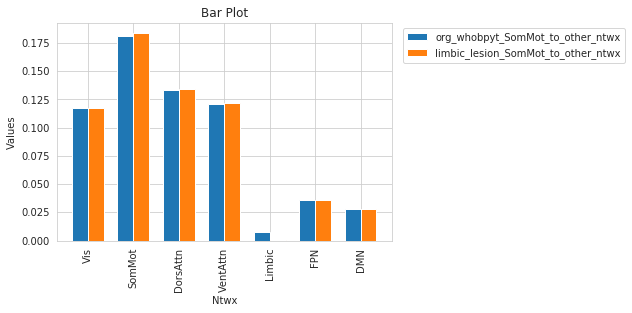

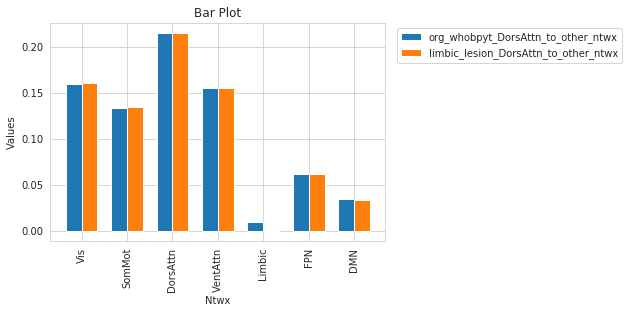

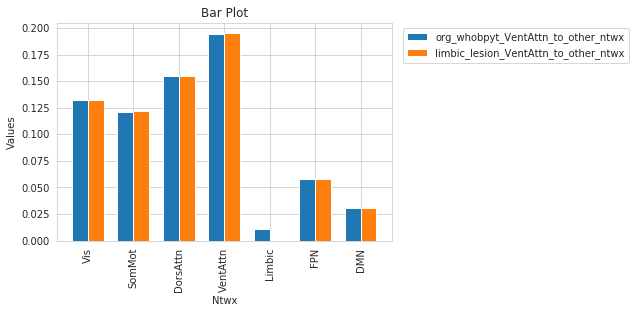

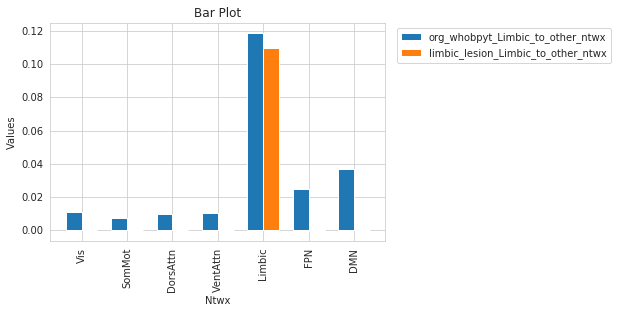

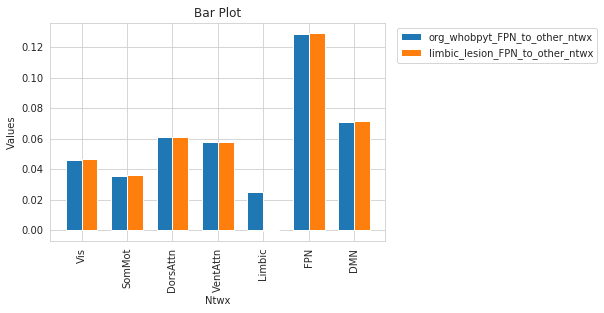

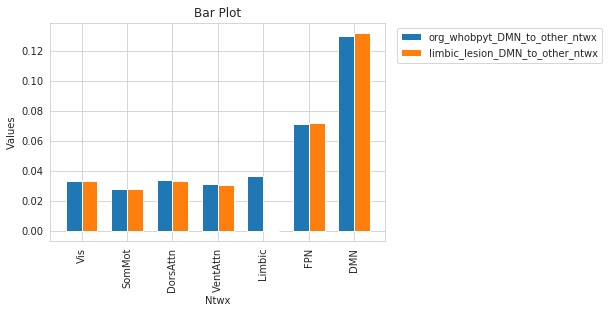

In [55]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], limbic_lesion_outer_to_other_ntwx[j], width, label='limbic_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### FPN

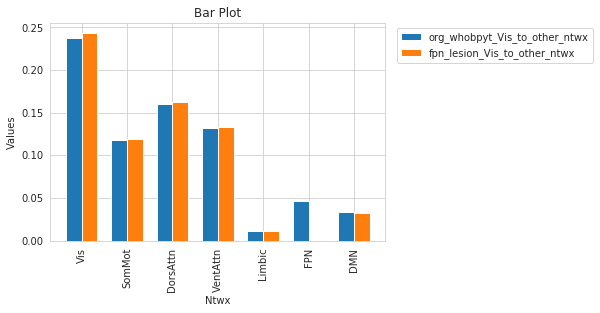

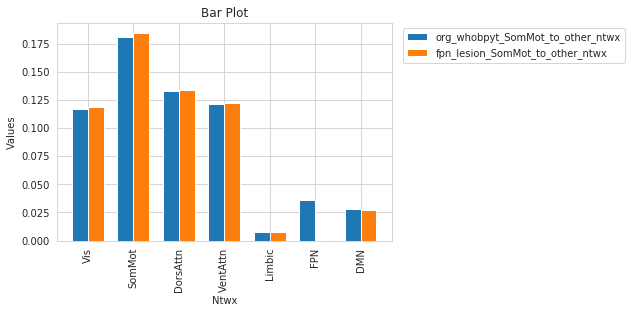

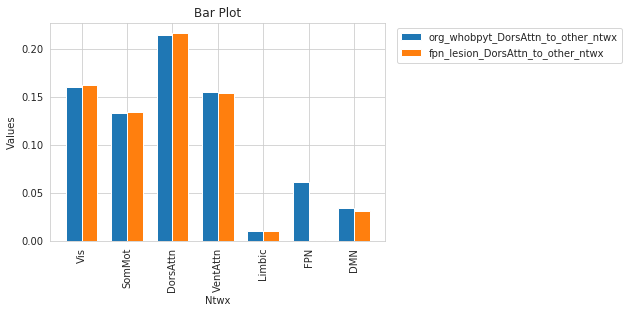

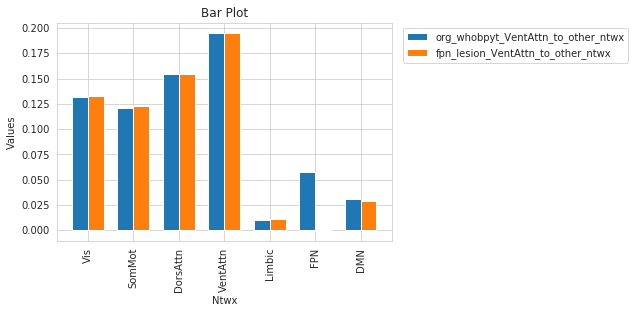

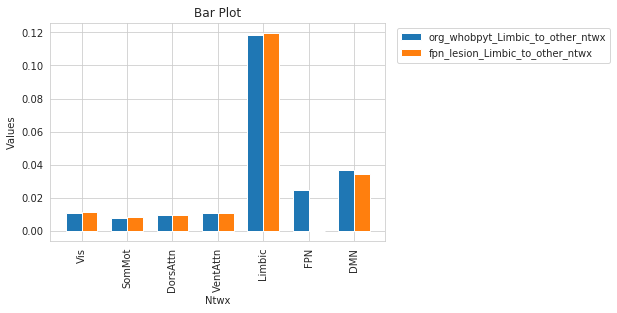

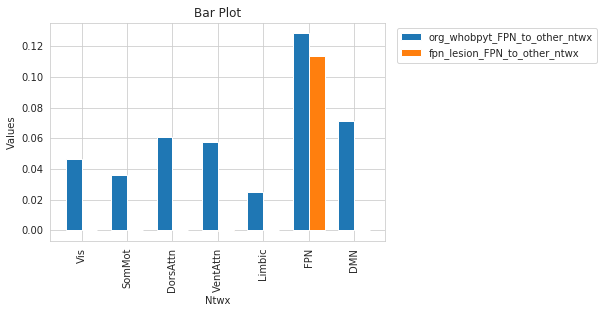

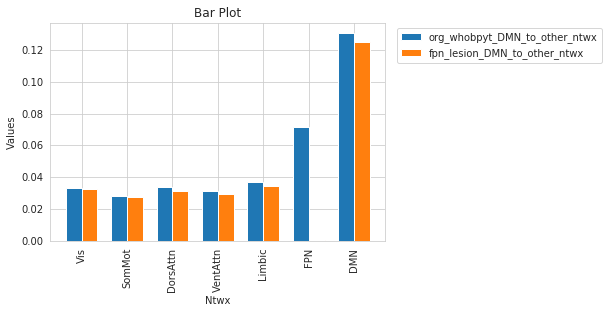

In [56]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], fpn_lesion_outer_to_other_ntwx[j], width, label='fpn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DMN

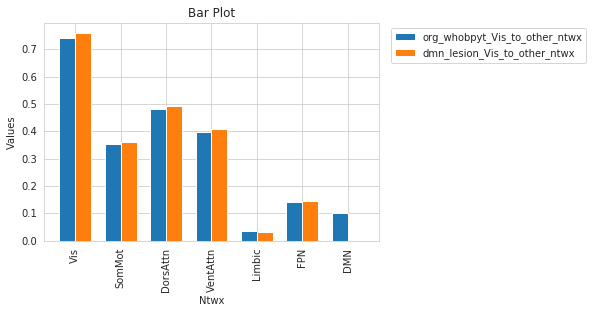

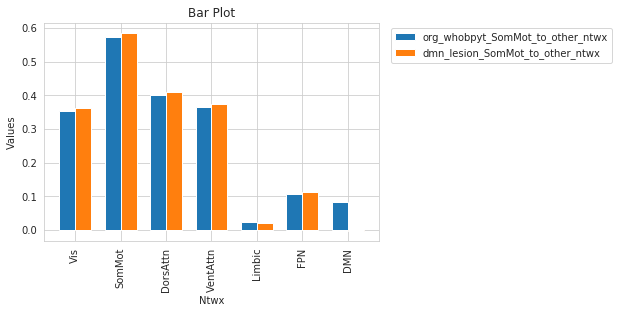

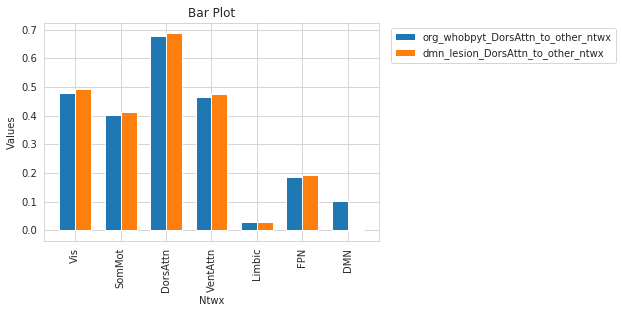

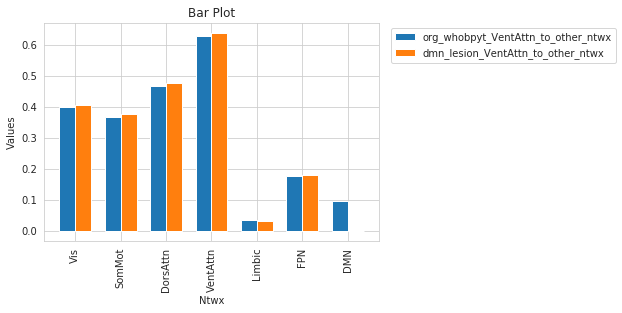

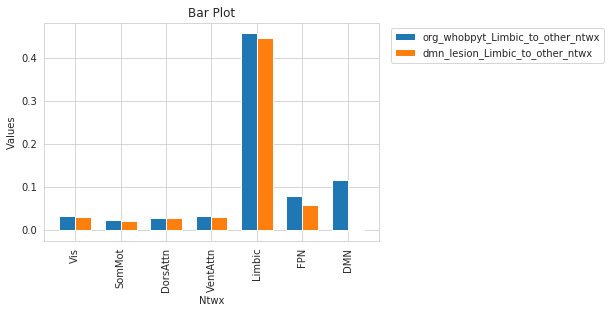

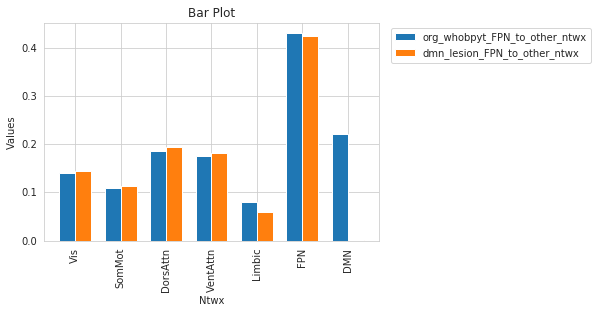

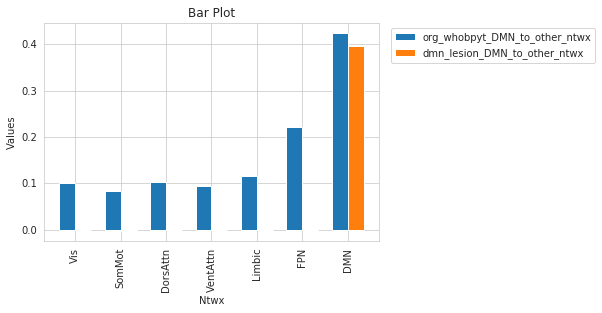

In [238]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], dmn_lesion_outer_to_other_ntwx[j], width, label='dmn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

In [237]:
print(og_whobpyt_outer_to_other_ntwx[6])
print(dmn_lesion_outer_to_other_ntwx[6])

[0.09993518499791362, 0.08458945991744132, 0.10226058190762685, 0.0948253858964843, 0.11624398154647625, 0.22171101371127697, 0.42394609914505993]
[0.00037334729435818643, -0.0018232326720597906, -0.0009637246354432502, -0.00021690579275790073, -0.0007604997043426152, 0.0011380176153535774, 0.39597191938109944]


### --------------------------------------------------------------------------------------------------------------------------------------------------------------

## Stats

In [77]:
Ntwx_labels

['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

In [225]:
# def stats_ttest_func(list1, list2):
    
#     t_statistic, p_value = stats.ttest_ind(list1, list2)
    
#     # Print the results
# #     print('Network = ', Ntwx_labels[i])
#     print("T-Statistic:", t_statistic)
#     print("P-Value:", p_value)
#     print('-------------------', '\n')

In [226]:
# t_stat, p_val = stats.ttest_ind(og_whobpyt_all_subs_outer_to_other_ntwx[0], vis_lesion_all_subs_outer_to_other_ntwx[0])

# print(t_stat)

# print(p_val)

### `vis` Lesion Stats

In [231]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(og_whobpyt_all_subs_outer_to_other_ntwx[i], vis_lesion_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[ 2.19910268 23.61882997 35.27203729 29.26189192 10.30978259 16.00131268
 13.96885024]
[2.84452314e-002 9.93440234e-078 1.48931593e-124 3.03273115e-101
 3.01235033e-022 7.49738242e-045 2.29632675e-036]
['0.0284452314', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000']
--------------------- 

SomMot to other ntwx stats 

[23.61882997  2.56898439  4.35573821  3.70885981  1.28864793  2.10337199
  3.14301328]
[9.93440234e-78 1.05632391e-02 1.68931088e-05 2.37758910e-04
 1.98269074e-01 3.60603995e-02 1.79742344e-03]
['0.0000000000', '0.0105632391', '0.0000168931', '0.0002377589', '0.1982690739', '0.0360603995', '0.0017974234']
--------------------- 

DorsAttn to other ntwx stats 

[35.27203729  4.35573821  6.00735397  5.49873173  1.64942961  2.3577163
  3.38649738]
[1.48931593e-124 1.68931088e-005 4.25870774e-009 6.85168906e-008
 9.98486431e-002 1.88708813e-002 7.78384326e-004]
['0.0000000000', '0.0000168931', '0.000000

### `smt` Lesion Stats

In [232]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(og_whobpyt_all_subs_outer_to_other_ntwx[i], smt_lesion_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-0.73741767 23.48410026  0.55651008  0.62978074  0.16885201  0.21853718
  0.65609059]
[4.61302905e-01 3.74871585e-77 5.78174967e-01 5.29199417e-01
 8.65998828e-01 8.27122605e-01 5.12144948e-01]
['0.4613029048', '0.0000000000', '0.5781749671', '0.5291994171', '0.8659988284', '0.8271226046', '0.5121449479']
--------------------- 

SomMot to other ntwx stats 

[23.48410026  7.63407274 28.34600883 30.77262803  8.46354166 14.49076826
 12.67787195]
[3.74871585e-077 1.70338999e-013 1.58683258e-097 2.76294053e-107
 5.02635167e-016 1.63294467e-038 3.57608894e-031]
['0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000']
--------------------- 

DorsAttn to other ntwx stats 

[ 5.56510080e-01  2.83460088e+01  1.38377217e+00  1.41557000e+00
 -1.95790941e-02  2.75658347e-01  8.62024926e-01]
[5.78174967e-01 1.58683258e-97 1.67203772e-01 1.57683462e-01
 9.84388953e-01 7.82953554e-01 3.89192879e-01]
['0.5781749671', '0.

### `dan` Lesion Stats

In [233]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(og_whobpyt_all_subs_outer_to_other_ntwx[i], dan_lesion_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[ 3.30373124  3.52107848 35.12561345  4.07811539  0.92843214  2.85799336
  2.03353905]
[1.04044453e-003 4.79558010e-004 5.21960408e-124 5.48528737e-005
 3.53746167e-001 4.48725661e-003 4.26609990e-002]
['0.0010404445', '0.0004795580', '0.0000000000', '0.0000548529', '0.3537461672', '0.0044872566', '0.0426609990']
--------------------- 

SomMot to other ntwx stats 

[ 3.52107848  2.65285958 28.4808299   3.46595673  0.08649827  2.87599967
  1.98944295]
[4.79558010e-04 8.30070862e-03 4.47209063e-98 5.85881365e-04
 9.31113834e-01 4.24403802e-03 4.73363514e-02]
['0.0004795580', '0.0083007086', '0.0000000000', '0.0005858814', '0.9311138340', '0.0042440380', '0.0473363514']
--------------------- 

DorsAttn to other ntwx stats 

[35.12561345 28.4808299  10.5766257  41.60635468  9.14969629 21.49771398
 15.0074572 ]
[5.21960408e-124 4.47209063e-098 3.31489463e-023 5.15924025e-147
 3.00494601e-018 1.35514649e-068 1.15721993e-040]
['0.0000000000', '0.0000000000', '0.00000

### `van` Lesion Stats

In [228]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(og_whobpyt_all_subs_outer_to_other_ntwx[i], van_lesion_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-0.19868876  1.1549156   1.11309114 29.19585693  0.55158623  0.98976491
  0.38940385]
[8.42607675e-001 2.48817917e-001 2.66341102e-001 5.60459756e-101
 5.81541420e-001 3.22890377e-001 6.97185699e-001]
['0.8426076750', '0.2488179171', '0.2663411018', '0.0000000000', '0.5815414199', '0.3228903773', '0.6971856995']
--------------------- 

SomMot to other ntwx stats 

[ 1.1549156   1.36195679  2.37999537 30.78969874  0.50767375  1.77564433
  0.68945204]
[2.48817917e-001 1.73981872e-001 1.77830592e-002 2.36481528e-107
 6.11963370e-001 7.65556053e-002 4.90940608e-001]
['0.2488179171', '0.1739818722', '0.0177830592', '0.0000000000', '0.6119633698', '0.0765556053', '0.4909406085']
--------------------- 

DorsAttn to other ntwx stats 

[ 1.11309114  2.37999537  2.81125781 41.59526323  0.57116634  1.7361342
  0.77451903]
[2.66341102e-001 1.77830592e-002 5.17880493e-003 5.62438524e-147
 5.68209266e-001 8.33139669e-002 4.39083784e-001]
['0.2663411018', '0.0177830592', '0

### `lim` Lesion Stats

In [172]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(og_whobpyt_all_subs_outer_to_other_ntwx[i], lim_lesion_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-8.80526740e-02 -6.88696248e-03 -8.77320782e-02  3.13980447e-02
  9.23576632e+00 -1.19246365e-01  6.66325297e-02]
[9.29879098e-01 9.94508493e-01 9.30133747e-01 9.74967839e-01
 1.55286649e-18 9.05140341e-01 9.46907707e-01]
['0.9298790975', '0.9945084930', '0.9301337474', '0.9749678395', '0.0000000000', '0.9051403406', '0.9469077068']
--------------------- 

SomMot to other ntwx stats 

[-6.88696248e-03 -3.21815668e-01 -1.10922218e-01 -1.87466904e-01
  7.76216749e+00 -1.21170302e-01  4.17587874e-02]
[9.94508493e-01 7.47761297e-01 9.11733940e-01 8.51390103e-01
 7.12032801e-14 9.03617297e-01 9.66711930e-01]
['0.9945084930', '0.7477612968', '0.9117339402', '0.8513901028', '0.0000000000', '0.9036172966', '0.9667119296']
--------------------- 

DorsAttn to other ntwx stats 

[-0.08773208 -0.11092222 -0.02069988 -0.06008111  9.06634927 -0.03496252
  0.19808696]
[9.30133747e-01 9.11733940e-01 9.83495438e-01 9.52121194e-01
 5.67354525e-18 9.72127159e-01 8.43078160e-01]

### `fpn` Lesion Stats

In [235]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(og_whobpyt_all_subs_outer_to_other_ntwx[i], fpn_lesion_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-1.12348081 -0.23352335 -0.37367415 -0.19466933 -0.5344307  16.14276274
  0.21989627]
[2.61910549e-01 8.15475101e-01 7.08845725e-01 8.45751155e-01
 5.93341985e-01 1.87884611e-45 8.26064683e-01]
['0.2619105489', '0.8154751011', '0.7088457254', '0.8457511550', '0.5933419852', '0.0000000000', '0.8260646830']
--------------------- 

SomMot to other ntwx stats 

[-0.23352335 -0.51205263 -0.18265975 -0.25841052 -0.38500803 14.73327694
  0.28495752]
[8.15475101e-01 6.08898188e-01 8.55158006e-01 7.96223676e-01
 7.00437129e-01 1.60969734e-39 7.75824910e-01]
['0.8154751011', '0.6088981879', '0.8551580060', '0.7962236756', '0.7004371286', '0.0000000000', '0.7758249104']
--------------------- 

DorsAttn to other ntwx stats 

[-0.37367415 -0.18265975 -0.25873476  0.02294405 -0.05232051 21.27662342
  0.83444601]
[7.08845725e-01 8.55158006e-01 7.95973656e-01 9.81706400e-01
 9.58299558e-01 1.22890902e-67 4.04530267e-01]
['0.7088457254', '0.8551580060', '0.7959736557', '0.981

### `dmn` Lesion Stats

In [236]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(og_whobpyt_all_subs_outer_to_other_ntwx[i], dmn_lesion_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-1.27884636 -0.39608939 -0.64901444 -0.49938822  0.40710722 -0.39632908
 14.13787919]
[2.01696322e-01 6.92251343e-01 5.16703368e-01 6.17781857e-01
 6.84148098e-01 6.92074678e-01 4.65700285e-37]
['0.2016963222', '0.6922513433', '0.5167033675', '0.6177818565', '0.6841480978', '0.6920746777', '0.0000000000']
--------------------- 

SomMot to other ntwx stats 

[-0.39608939 -0.75701788 -0.47901053 -0.56817959  0.31038303 -0.49125799
 13.09946245]
[6.92251343e-01 4.49487058e-01 6.32194203e-01 5.70233435e-01
 7.56432163e-01 6.23514771e-01 7.56305915e-33]
['0.6922513433', '0.4494870582', '0.6321942032', '0.5702334351', '0.7564321635', '0.6235147708', '0.0000000000']
--------------------- 

DorsAttn to other ntwx stats 

[-0.64901444 -0.47901053 -0.64844321 -0.67182879  0.17394174 -0.64938988
 15.20758862]
[5.16703368e-01 6.32194203e-01 5.17072269e-01 5.02082479e-01
 8.61999687e-01 5.16460985e-01 1.67994427e-41]
['0.5167033675', '0.6321942032', '0.5170722692', '0.502